## Tugas Akhir 
## Teknik Pengolahan Citra Biomedis
# SEGMENTASI ATRIUM KIRI JANTUNG DARI CITRA MRI JANTUNG MENGGUNAKAN DEEP LEARNING
Disusun Oleh:
1. Alfian Daffa Baihaqi 20/456073/TK/50203
2. Nanda Ruben Bethelgusa 20/456077/TK/50207

# 1. Import Library

In [1]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

# 2. Persiapan Dataset

In [2]:
import os

folder_name = "imagesTr"  # Specify the name of the new folder

# Create the new folder
folder_path = os.path.join('/kaggle/working', folder_name)
os.makedirs(folder_path, exist_ok=True)

# Check if the folder was created successfully
if os.path.exists(folder_path):
    print("New folder created successfully.")
else:
    print("Failed to create the new folder.")


New folder created successfully.


In [3]:
folder_name = "labelsTr"  # Specify the name of the new folder

# Create the new folder
folder_path = os.path.join('/kaggle/working', folder_name)
os.makedirs(folder_path, exist_ok=True)

# Check if the folder was created successfully
if os.path.exists(folder_path):
    print("New folder created successfully.")
else:
    print("Failed to create the new folder.")


New folder created successfully.


In [4]:
# Menyatukan image training dan lebel ke dalam satu directory

import os
import shutil

source_directory = '/kaggle/input/heart-mri-image-dataset-left-atrial-segmentation/imagesTr'
destination_directory = '/kaggle/working/imagesTr'  # Modify the destination directory as per your requirements

# Copy and rename files in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith('.nii'):
        old_path = os.path.join(source_directory, filename)
        new_filename = 'Training' + filename  # Modify the new filename as per your requirements
        new_path = os.path.join(destination_directory, new_filename)
        shutil.copy2(old_path, new_path)

# Repeat the same process for the labels directory
source_directory = '/kaggle/input/heart-mri-image-dataset-left-atrial-segmentation/labelsTr'
destination_directory = '/kaggle/working/labelsTr'  # Modify the destination directory as per your requirements

# Copy and rename files in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith('.nii'):
        old_path = os.path.join(source_directory, filename)
        new_filename = 'Label' + filename  # Modify the new filename as per your requirements
        new_path = os.path.join(destination_directory, new_filename)
        shutil.copy2(old_path, new_path)


In [5]:
# Buat file meta untuk pemrosesan file .nii

file_list = []
for dirname, _, filenames in os.walk('/kaggle/working/imagesTr'):
    for filename in filenames:
        file_list.append((dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/working/labelsTr'):
    for filename in filenames:
        file_list.append((dirname, filename))

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename'])
df_files.sort_values(by=['filename'], ascending=True)
df_files

,dirname,filename
0,/kaggle/working/imagesTr,Trainingla_019.nii
1,/kaggle/working/imagesTr,Trainingla_018.nii
2,/kaggle/working/imagesTr,Trainingla_004.nii
3,/kaggle/working/imagesTr,Trainingla_003.nii
4,/kaggle/working/imagesTr,Trainingla_007.nii
5,/kaggle/working/imagesTr,Trainingla_009.nii
6,/kaggle/working/imagesTr,Trainingla_022.nii
7,/kaggle/working/imagesTr,Trainingla_017.nii
8,/kaggle/working/imagesTr,Trainingla_010.nii
9,/kaggle/working/imagesTr,Trainingla_005.nii


In [6]:
df_files.to_csv("df_files.csv", index=False)

In [7]:
# Map Citra MRI dan Labelnya

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(9):
    mri = f"Trainingla_00{i}.nii"
    mask = f"Labella_00{i}.nii"

    df_files.loc[df_files['filename'] == mri, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == mri, 'mask_dirname'] = "labelsTr"

for i in range(30):
    mri = f"Trainingla_0{i}.nii"
    mask = f"Labella_0{i}.nii"

    df_files.loc[df_files['filename'] == mri, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == mri, 'mask_dirname'] = "labelsTr"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)

df_files

,dirname,filename,mask_dirname,mask_filename
0,/kaggle/working/imagesTr,Trainingla_003.nii,labelsTr,Labella_003.nii
1,/kaggle/working/imagesTr,Trainingla_004.nii,labelsTr,Labella_004.nii
2,/kaggle/working/imagesTr,Trainingla_005.nii,labelsTr,Labella_005.nii
3,/kaggle/working/imagesTr,Trainingla_007.nii,labelsTr,Labella_007.nii
4,/kaggle/working/imagesTr,Trainingla_010.nii,labelsTr,Labella_010.nii
5,/kaggle/working/imagesTr,Trainingla_011.nii,labelsTr,Labella_011.nii
6,/kaggle/working/imagesTr,Trainingla_014.nii,labelsTr,Labella_014.nii
7,/kaggle/working/imagesTr,Trainingla_016.nii,labelsTr,Labella_016.nii
8,/kaggle/working/imagesTr,Trainingla_017.nii,labelsTr,Labella_017.nii
9,/kaggle/working/imagesTr,Trainingla_018.nii,labelsTr,Labella_018.nii


In [8]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    MRI = nib.load(filepath)
    array   = MRI.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [9]:
# Read sample
sample = 0
sample_mri = read_nii(df_files.loc[sample,'dirname'] + "/" + df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'MRI Shape:   {sample_mri.shape}\nMask Shape: {sample_mask.shape}')

MRI Shape:   (320, 320, 130)
Mask Shape: (320, 320, 130)


In [10]:
print(np.amin(sample_mri), np.amax(sample_mri))
print(np.amin(sample_mask), np.amax(sample_mask))

0.0 1999.0
0.0 1.0


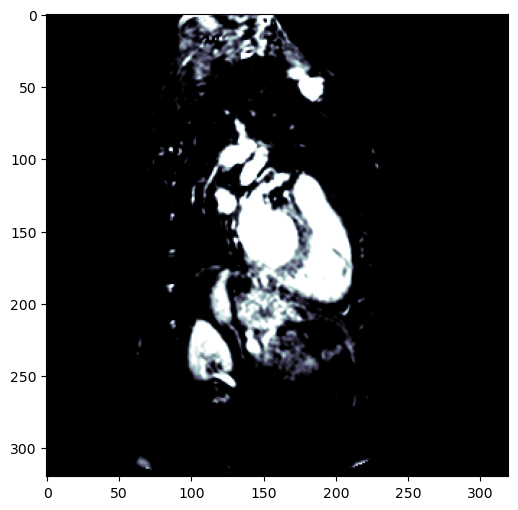

In [11]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60),
    heart = (400,600)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_mri[..., 55].astype(np.float32)).windowed(*dicom_windows.heart), cmap=plt.cm.bone);

In [18]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.heart), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.8, cmap=color_map)
    plt.title('Heart')
    plt.axis('off')
    
    plt.show()

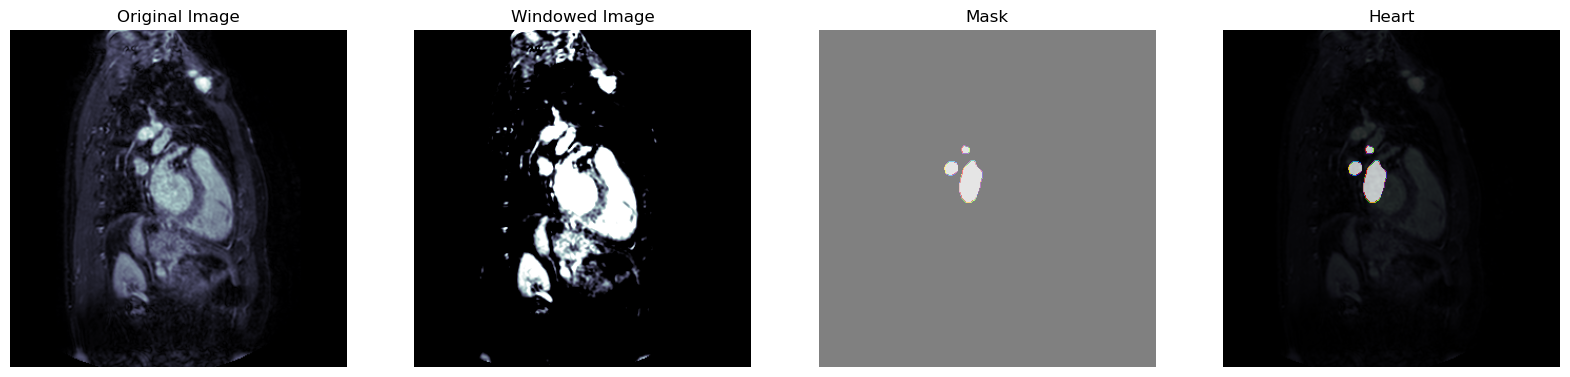

In [19]:
sample = 55

sample_slice = torch.tensor(sample_mri[...,sample].astype(np.float32))

plot_sample([sample_mri[..., sample],
             sample_mask[..., sample]])

In [20]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print(np.array((unique, counts)).T)

[[     0 101590]
 [     1    810]]


<Axes: >

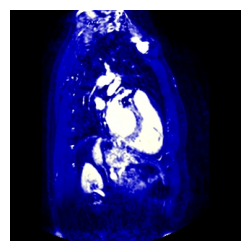

In [21]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorMRI(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorMRI(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.heart, dicom_windows.heart])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

In [22]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),2)): # take 1/3 nii files for training
        curr_mri        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_mri.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_mri[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.heart,dicom_windows.heart])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("/kaggle/input/heart-mri-image-dataset-left-atrial-segmentation") # read jpg from saved kernel output

  0%|          | 0/9 [00:00<?, ?it/s]

# 3. Model Training

In [23]:
BATCH_SIZE = 4 
IMAGE_SIZE = 320

codes = np.array(["background","heart"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  
               splitter=RandomSplitter(),
               item_tfms=[Resize(IMAGE_SIZE)],
               get_items=get_image_files,
               get_y=label_func)

ds = db.datasets(source=path/'train_images')

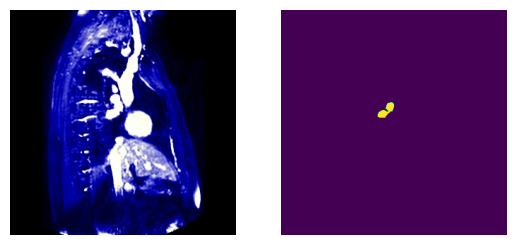

In [24]:
idx = 20
imgs = [ds[idx][0],ds[idx][1]]
fig, axs = plt.subplots(1, 2)

for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i])

In [25]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)

[[     0 102148]
 [     1    252]]


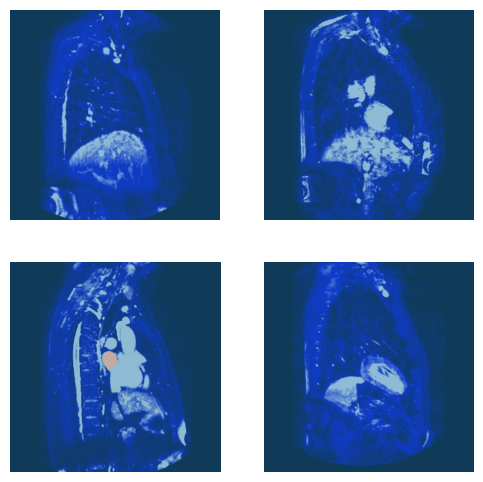

In [26]:
dls = db.dataloaders(path/'train_images', bs = BATCH_SIZE) #, num_workers=0
dls.show_batch()

In [27]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=2, axis=1) # 3 is a dummy value to include the background which is 0

In [28]:
learn = unet_learner(dls,
                     resnet50,
                     loss_func=CrossEntropyLossFlat(axis=1),
                     metrics=[foreground_acc, cust_foreground_acc]) 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


In [30]:
import torch
torch.cuda.empty_cache()

In [31]:
learn.fine_tune(5, wd=0.1, cbs=SaveModelCallback() )

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.025921,0.014242,0.000000,0.995684,02:35


Better model found at epoch 0 with valid_loss value: 0.014242248609662056.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.006932,0.009353,0.247884,0.996875,02:33
1,0.005767,0.002963,0.708030,0.998734,02:33
2,0.002416,0.002036,0.839000,0.999155,02:32
3,0.001579,0.001625,0.916239,0.999306,02:30
4,0.001304,0.001574,0.906044,0.999307,02:30


Better model found at epoch 0 with valid_loss value: 0.009353014640510082.
Better model found at epoch 1 with valid_loss value: 0.002962977159768343.
Better model found at epoch 2 with valid_loss value: 0.0020361521746963263.
Better model found at epoch 3 with valid_loss value: 0.0016246323939412832.
Better model found at epoch 4 with valid_loss value: 0.0015741141978651285.


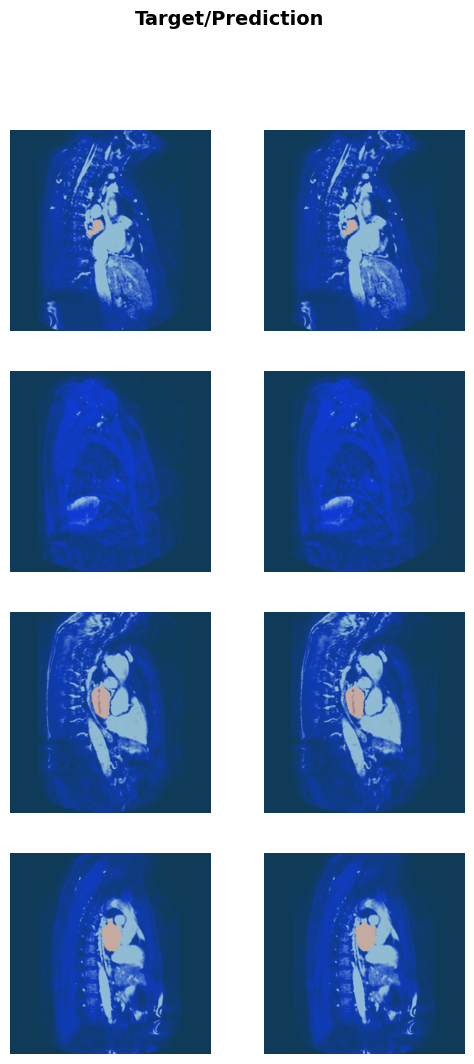

In [32]:
learn.show_results()

In [33]:
# Save the model
learn.export(path/f'Heart_segmentation')

# 4. Testing

In [34]:
# Load saved model
if (GENERATE_JPG_FILES) :
    
    tfms = [Resize(IMAGE_SIZE), IntToFloatTensor(),Normalize()]
    learn0 = load_learner(path/f'Heart_segmentation',cpu=False )
    learn0.dls.transform = tfms


In [35]:
def nii_tfm(fn,wins): 

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []
    
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
                      
    return slices

(320, 320, 120)


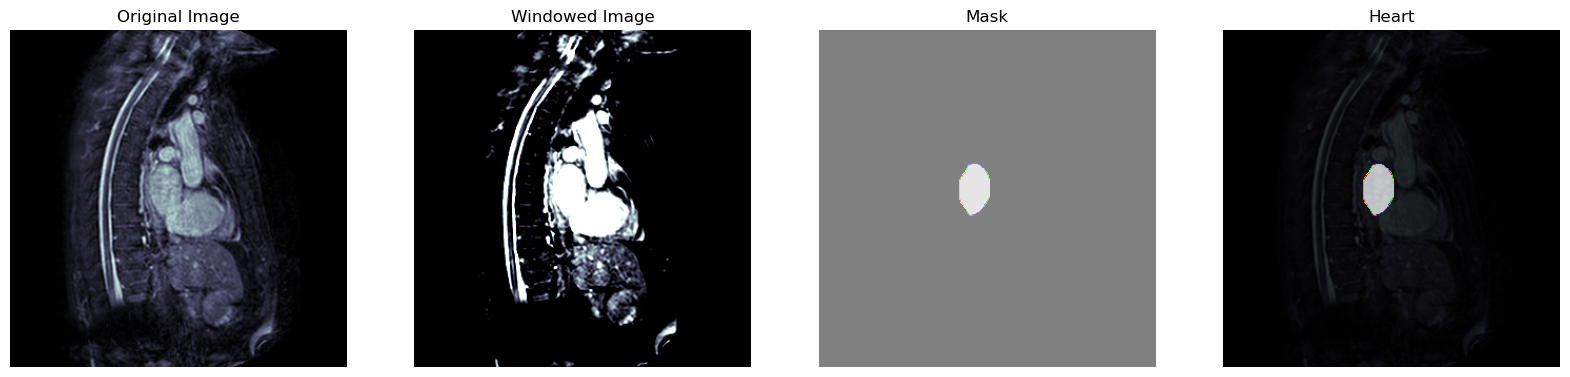

In [36]:
tst = 5

test_nii   = read_nii(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'])
test_mask  = read_nii(df_files.loc[tst,'mask_dirname']+"/"+df_files.loc[tst,'mask_filename'])
print(test_nii.shape)

test_slice_idx = 80

sample_slice = tensor(test_nii[...,test_slice_idx].astype(np.float32))

plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])

In [37]:
# Prepare a nii test file for prediction 

test_files = nii_tfm(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'],[dicom_windows.heart, dicom_windows.heart])
print("Number of test slices: ", len(test_files))

Number of test slices:  120


<Axes: >

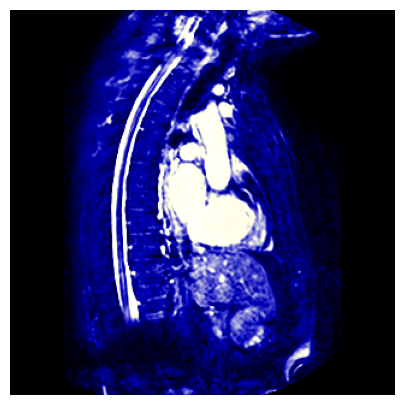

In [38]:
# Check an input for a test file
show_image(test_files[test_slice_idx])

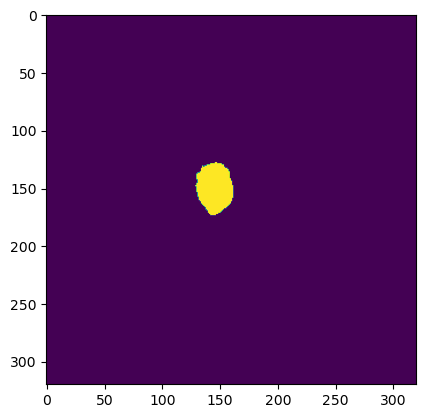

In [39]:
# Get predictions for a Test file

test_dl = learn0.dls.test_dl(test_files)
preds, y = learn0.get_preds(dl=test_dl)

predicted_mask = np.argmax(preds, axis=1)

plt.imshow(predicted_mask[test_slice_idx])

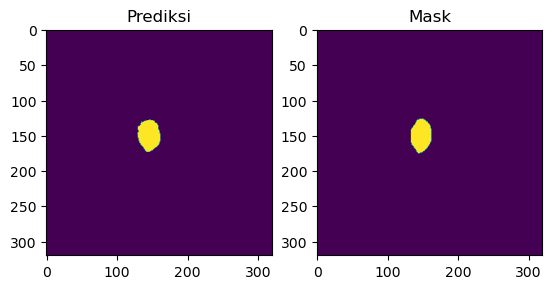

In [40]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    
    plt.subplot(1,2,1)
    plt.imshow(predicted_mask[test_slice_idx])
    plt.title('Prediksi')
    plt.axis('on')
    
    plt.subplot(1,2,2)
    plt.imshow(array_list[1])
    plt.title('Mask')
    plt.axis('on')
    
    plt.show()
plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])



# 5. Evaluation

In [41]:
import numpy as np

   
def calculate_accuracy(test_mask, Predict_array):
    correct = np.sum(test_mask == Predict_array)
    total = np.prod(test_mask.shape)
    accuracy = correct / total
    return accuracy

def intersection_over_union(prediction, ground_truth):
    intersection = np.logical_and(prediction, ground_truth)
    union = np.logical_or(prediction, ground_truth)

    intersection_sum = np.sum(intersection)
    union_sum = np.sum(union)
    
    if union_sum == 0:
        return 1.0
    
    iou = intersection_sum / union_sum
    return iou

def dice_coefficient(prediction, ground_truth):
    intersection = np.logical_and(prediction, ground_truth)
    intersection_sum = np.sum(intersection)
    union_sum = np.sum(prediction) + np.sum(ground_truth)
    
    if union_sum == 0:
        return 1.0
    
    dice = (2.0 * intersection_sum) / union_sum
    return dice


accuracy_scores = []
dice_coefficients = []
IoU = []

for slicee in range(120):
    predictt = predicted_mask[slicee]
    test_1 = test_mask[...,slicee]
    Predict_array1 = predictt.numpy()
    
    iou = intersection_over_union(test_1, Predict_array1)
    dice = dice_coefficient(test_1, Predict_array1)
    acc = calculate_accuracy(test_1, Predict_array1)
    
    accuracy_scores.append(acc)
    dice_coefficients.append(dice)
    IoU.append(iou)
 
print("Accuracy:", np.mean(accuracy_scores))
print("Dice:", np.mean(dice_coefficients))
print("IoU:", np.mean(IoU))

Accuracy: 0.9986105143229167
Dice: 0.8284022518228125
IoU: 0.7794577144231413
